In [28]:
import matplotlib.pyplot as plt
import numpy as np

from hazma.scalar_mediator import ScalarMediator

In [4]:
gsxx = 1.0
gsff = 1.0
gsGG = 1.0
gsFF = 1.0
ms = 1.0
mx = 140.

sm = ScalarMediator(mx, ms, gsxx, gsff, gsGG, gsFF)

### e-ASTROGAM's effective area

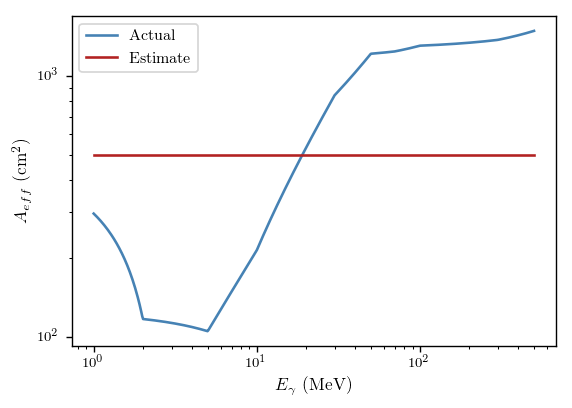

In [18]:
from hazma.gamma_ray_limits.gamma_ray_limit_parameters import A_eff_e_ASTROGAM

e_gams = np.logspace(0, np.log10(500), 500)

plt.loglog(e_gams, [A_eff_e_ASTROGAM(e) for e in e_gams], label="Actual")
plt.loglog(e_gams[[0, -1]], [500, 500], label="Estimate")

plt.xlabel(r"$E_\gamma$ (MeV)")
plt.ylabel(r"$A_{\text{eff}}$ (cm$^2$)")
plt.legend()

### DM annihilation spectra

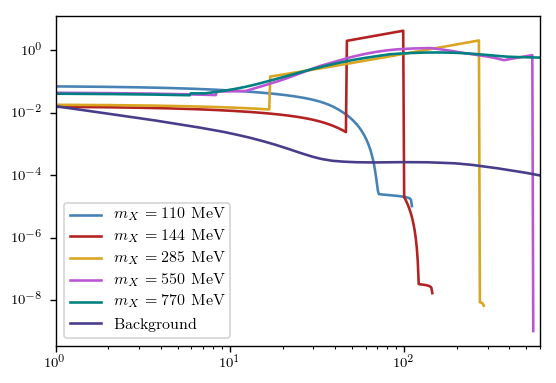

In [77]:
e_gams = np.logspace(0, np.log10(600), 500)

# DM spectra
for mx in [110., 144., 285., 550., 770.]:
    sm.mx = mx
    spectra = sm.spectra(e_gams, 2.01*mx)
    plt.loglog(e_gams, e_gams * spectra["total"], label=r"$m_X = %.0f$ MeV" % mx)

# Background spectrum
plt.loglog(gamma_ray_limit_parameters.e_Bs, gamma_ray_limit_parameters.e_Bs * gamma_ray_limit_parameters.dPhi_dEdOmega_Bs, label="Background")

plt.xlim(e_gams[[0, -1]])
plt.legend()

### Unoptimized energy window

In [15]:
mx_min = 100.
mx_max = 1000.
n_mxs = 100

mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)

# Compute limits
sv_lims = sm.compute_limits(mxs)

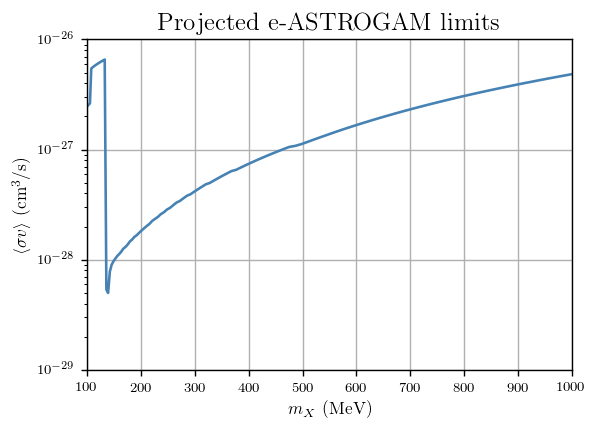

In [16]:
plt.plot(mxs, sv_lims)

plt.grid()
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-29, 1e-26])
plt.yscale("log")
plt.xlabel(r"$m_X$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.title("Projected e-ASTROGAM limits")

### Optimizing energy window

In [78]:
from scipy.optimize import fsolve, minimize
from scipy.interpolate import interp1d
from scipy.integrate import quad

from hazma.gamma_ray_limits import gamma_ray_limit_parameters
from hazma.parameters import neutral_pion_mass as mpi0

#### Optimizing lower bound only

In [ ]:
mx_min = 140.
mx_max = 1000.
n_mxs = 10

mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)
optimal_limits = []
suboptimal_limits = []

for mx in mxs:
    sm.mx = mx
    spectrum = sm.spectra(e_gams, 2.01*mx)["total"]
    
    e_gams = np.logspace(0, np.log10(2000), 500)
    # Interpolate DM spectrum
    dnde_dm = interp1d(e_gams, spectrum)

    e_b = mx / 2. * (1. + np.sqrt(1. - mpi0**2 / mx**2))  # maximum photon energy from pi0's decay
    e_a_0 = mx / 2. * (1. - np.sqrt(1. - mpi0**2 / mx**2))  # minimum photon energy from pi0's decay

    def I_S(a, b=e_b):
        return quad(lambda e: gamma_ray_limit_parameters.A_eff_e_ASTROGAM(e) * dnde_dm(e), a, b)[0]

    def I_B(a, b=e_b):
        return quad(lambda e: gamma_ray_limit_parameters.A_eff_e_ASTROGAM(e) * gamma_ray_limit_parameters.dPhi_dEdOmega_B_default(e), a, b)[0]

    def to_optimize(a):
        return dnde_dm(a) - 0.5 * I_S(a) / I_B(a) * gamma_ray_limit_parameters.dPhi_dEdOmega_B_default(a)

    # Find optimal lower bound for energy window
    e_a_optimal = fsolve(to_optimize, e_a_0, xtol=1e-4)
    
    optimal_limits.append(compute_limits.compute_limit(dnde_dm, mx, e_a_optimal, e_b))
    suboptimal_limits.append(compute_limits.compute_limit(dnde_dm, mx, mpi0 / 2., mx))
    
optimal_limits = np.array(optimal_limits)
suboptimal_limits = np.array(suboptimal_limits)

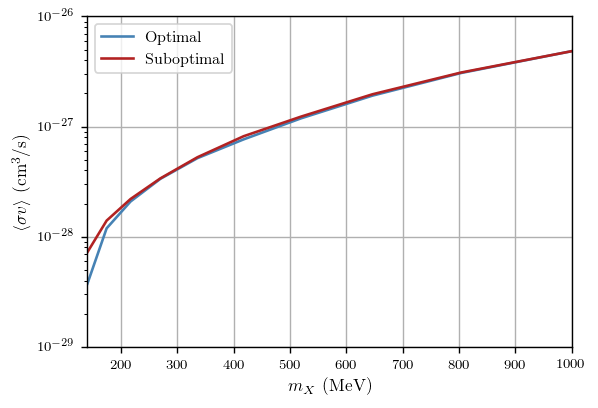

In [76]:
plt.plot(mxs, optimal_limits, label="Optimal")
plt.plot(mxs, suboptimal_limits, label="Suboptimal")

plt.grid()
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-29, 1e-26])
plt.yscale("log")
plt.xlabel(r"$m_X$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.legend()

#### Optimizing upper and lower bounds

In [106]:
mx_min = 144.
mx_max = 1000.
n_mxs = 10
mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)

optimal_limits = []
suboptimal_limits = []

for mx in mxs:
    sm.mx = mx
    spectrum = sm.spectra(e_gams, 2.01*mx)["total"]
    
    e_gams = np.logspace(0, np.log10(2000), 500)
    # Interpolate DM spectrum
    dnde_dm = interp1d(e_gams, spectrum)

    e_b_0 = mx / 2. * (1. + np.sqrt(1. - mpi0**2 / mx**2))  # maximum photon energy from pi0's decay
    e_a_0 = mx / 2. * (1. - np.sqrt(1. - mpi0**2 / mx**2))  # minimum photon energy from pi0's decay

    def I_S(a, b):
        return quad(lambda e: gamma_ray_limit_parameters.A_eff_e_ASTROGAM(e) * dnde_dm(e), a, b)[0]

    def I_B(a, b):
        return quad(lambda e: gamma_ray_limit_parameters.A_eff_e_ASTROGAM(e) * gamma_ray_limit_parameters.dPhi_dEdOmega_B_default(e), a, b)[0]

    def to_optimize(ab):
        return -I_S(ab[0], ab[1]) / np.sqrt(I_B(ab[0], ab[1]))

    # Find optimal energy window
    e_window = minimize(to_optimize, [e_a_0, e_b_0], tol=1e-4, bounds=[[e_gams[0], mpi0 / 2.0001], [mpi0 / 1.9999, mx]]).x
    
    if e_window[0] < e_window[1]:
        e_a_optimal = e_window[0]
        e_b_optimal = e_window[1]
    else:
        e_a_optimal = e_window[1]
        e_b_optimal = e_window[0]
        
    print("m_X: ", mx, " MeV")
    print("Optimal [E_a, E_b]: ", e_window)
    print("Suboptimal [E_a, E_b]: ", (e_a_0, e_b_0))
    print("Stefano's [E_a, E_b]: ", (mpi0 / 2., mx))
    print("")
    
    optimal_limits.append(compute_limits.compute_limit(dnde_dm, mx, e_a_optimal, e_b_optimal))
    suboptimal_limits.append(compute_limits.compute_limit(dnde_dm, mx, mpi0 / 2., mx))
    
optimal_limits = np.array(optimal_limits)
suboptimal_limits = np.array(suboptimal_limits)

('m_X: ', 144.00000000000003, ' MeV')
('Optimal [E_a, E_b]: ', array([46.91356217, 97.08643783]))
("Stefano's [E_a, E_b]: ", (67.4883, 144.00000000000003))

('m_X: ', 178.59848507376822, ' MeV')
('Optimal [E_a, E_b]: ', array([ 30.82117758, 147.77730749]))
("Stefano's [E_a, E_b]: ", (67.4883, 178.59848507376822))

('m_X: ', 221.50985326836783, ' MeV')
('Optimal [E_a, E_b]: ', array([ 22.93702905, 198.57282422]))
("Stefano's [E_a, E_b]: ", (67.4883, 221.50985326836783))

('m_X: ', 274.7314182127998, ' MeV')
('Optimal [E_a, E_b]: ', array([ 17.72178991, 257.00962831]))
("Stefano's [E_a, E_b]: ", (67.4883, 274.7314182127998))

('m_X: ', 340.740382603985, ' MeV')
('Optimal [E_a, E_b]: ', array([ 13.93703801, 326.80334459]))
("Stefano's [E_a, E_b]: ", (67.4883, 340.740382603985))

('m_X: ', 422.6091398369991, ' MeV')
('Optimal [E_a, E_b]: ', array([ 11.06733404, 411.5418058 ]))
("Stefano's [E_a, E_b]: ", (67.4883, 422.6091398369991))

('m_X: ', 524.1482788417792, ' MeV')
('Optimal [E_a, E_b

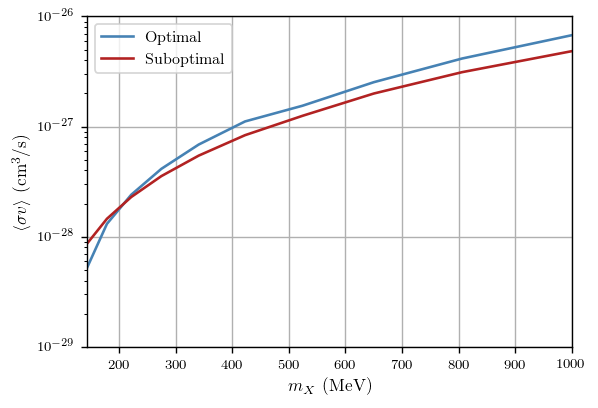

In [107]:
plt.plot(mxs, optimal_limits, label="Optimal")
plt.plot(mxs, suboptimal_limits, label="Suboptimal")

plt.grid()
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-29, 1e-26])
plt.yscale("log")
plt.xlabel(r"$m_X$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.legend()

In [119]:
mx_min = 144.
mx_max = 1000.
n_mxs = 5
mxs = np.logspace(np.log10(mx_min), np.log10(mx_max), n_mxs)

optimal_limits = []
suboptimal_limits = []

for mx in mxs:
    sm.mx = mx
    spectrum = sm.spectra(e_gams, 2.01*mx)["total"]
    
    e_gams = np.logspace(0, np.log10(2000), 500)
    # Interpolate DM spectrum
    dnde_dm = interp1d(e_gams, spectrum)

    e_b_0 = mx / 2. * (1. + np.sqrt(1. - mpi0**2 / mx**2))  # maximum photon energy from pi0's decay
    e_a_0 = mx / 2. * (1. - np.sqrt(1. - mpi0**2 / mx**2))  # minimum photon energy from pi0's decay

    def I_S(a, b):
        return quad(lambda e: gamma_ray_limit_parameters.A_eff_e_ASTROGAM(e) * dnde_dm(e), a, b)[0]

    def I_B(a, b):
        return quad(lambda e: gamma_ray_limit_parameters.A_eff_e_ASTROGAM(e) * gamma_ray_limit_parameters.dPhi_dEdOmega_B_default(e), a, b)[0]

    def to_optimize(ab):
#         return compute_limits.compute_limit(dnde_dm, sm.mx, ab[0], ab[1])
        return -I_S(ab[0], ab[1]) / np.sqrt(I_B(ab[0], ab[1]))

    # Find optimal energy window
    e_window = minimize(to_optimize, [e_a_0, e_b_0], bounds=[[e_gams[0], mpi0 / 2.0001], [mpi0 / 1.9999, mx]])
    e_a_optimal = e_window.x[0]
    e_b_optimal = e_window.x[1]
        
    print("m_X: ", mx, " MeV")
    print("Optimal [E_a, E_b]: ", e_window.x)
    print("Stefano's [E_a, E_b]: ", (mpi0 / 2., mx))
    print("")
    
#     optimal_limits.append(e_window.fun)
    optimal_limits.append(compute_limits.compute_limit(dnde_dm, mx, e_a_optimal, e_b_optimal))
    suboptimal_limits.append(compute_limits.compute_limit(dnde_dm, mx, mpi0 / 2., mx))
    
optimal_limits = np.array(optimal_limits)
suboptimal_limits = np.array(suboptimal_limits)

('m_X: ', 144.00000000000003, ' MeV')
('Optimal [E_a, E_b]: ', array([46.29201225, 98.97407601]))
("Stefano's [E_a, E_b]: ", (67.4883, 144.00000000000003))

('m_X: ', 233.76089914207122, ' MeV')
('Optimal [E_a, E_b]: ', array([ 61.58649864, 215.52400461]))
("Stefano's [E_a, E_b]: ", (67.4883, 233.76089914207122))

('m_X: ', 379.4733192202058, ' MeV')
('Optimal [E_a, E_b]: ', array([ 67.48492575, 373.48369417]))
("Stefano's [E_a, E_b]: ", (67.4883, 379.4733192202058))

('m_X: ', 616.0140576482048, ' MeV')
('Optimal [E_a, E_b]: ', array([ 43.79800134, 616.01405765]))
("Stefano's [E_a, E_b]: ", (67.4883, 616.0140576482048))

('m_X: ', 1000.0, ' MeV')
('Optimal [E_a, E_b]: ', array([  59.228818, 1000.      ]))
("Stefano's [E_a, E_b]: ", (67.4883, 1000.0))



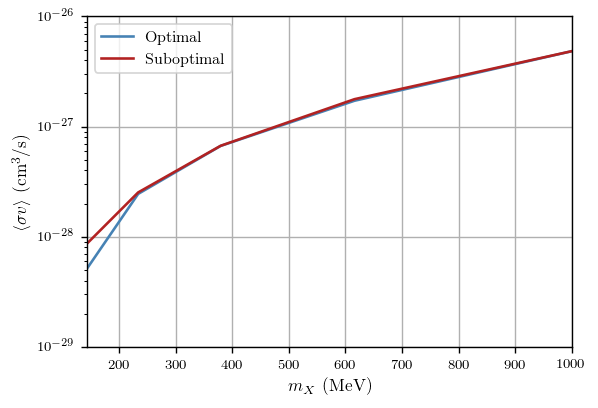

In [120]:
plt.plot(mxs, optimal_limits, label="Optimal")
plt.plot(mxs, suboptimal_limits, label="Suboptimal")

plt.grid()
plt.xlim(mxs[[0, -1]])
plt.ylim([1e-29, 1e-26])
plt.yscale("log")
plt.xlabel(r"$m_X$ (MeV)")
plt.ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
plt.legend()